In [1]:
# Module imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cnn_plot import get_cat_index, plot_grid_40

from sklearn.model_selection import train_test_split

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import sklearn.metrics as metrics

Using TensorFlow backend.


In [2]:
# To mitigate error seen regarding multiple OpenMP initialized
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Using the "balanced" emnist data set
f_train   = '/Users/mflynn/Downloads/EMNIST/emnist/emnist-balanced-train.csv'
f_test    = '/Users/mflynn/Downloads/EMNIST/emnist/emnist-balanced-test.csv'
class_map = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

In [4]:
# Read emnist train and test data sets into respective dataframes
train = pd.read_csv(f_train, delimiter = ',')
test  = pd.read_csv(f_test,  delimiter = ',')
print(f'Train: {train.shape}, Test: {test.shape}')

Train: (112799, 785), Test: (18799, 785)


In [5]:
# Separate categories from data sets
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]

test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]

print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(112799, 784) (112799,) (18799, 784) (18799,)


In [6]:
# Function rotate to orient the data properly vertically and horizontally
HEIGHT = 28
WIDTH  = 28

def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [7]:
# Flip and rotate the train and test image data
train_x = np.asarray(train_x)
train_x = np.apply_along_axis(rotate, 1, train_x)

test_x  = np.asarray(test_x)
test_x  = np.apply_along_axis(rotate, 1, test_x)
print (f'train_x: {train_x.shape}\n test_x: {test_x.shape}')

train_x: (112799, 28, 28)
 test_x: (18799, 28, 28)


In [8]:
# Normalize the data
train_x = train_x.astype('float32')
train_x /= 255
test_x = test_x.astype('float32')
test_x /= 255

In [9]:
# Convience functions for plotting
def get_index(char=None) :
    global class_map, idx_y
    return get_cat_index (class_map, test_y, char)

def plot_grid(plt_idx) :
    global class_map, test_y, test_x
    return plot_grid_40(class_map, test_y, test_x, plt_idx)

<module 'matplotlib.pyplot' from '/Users/mflynn/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

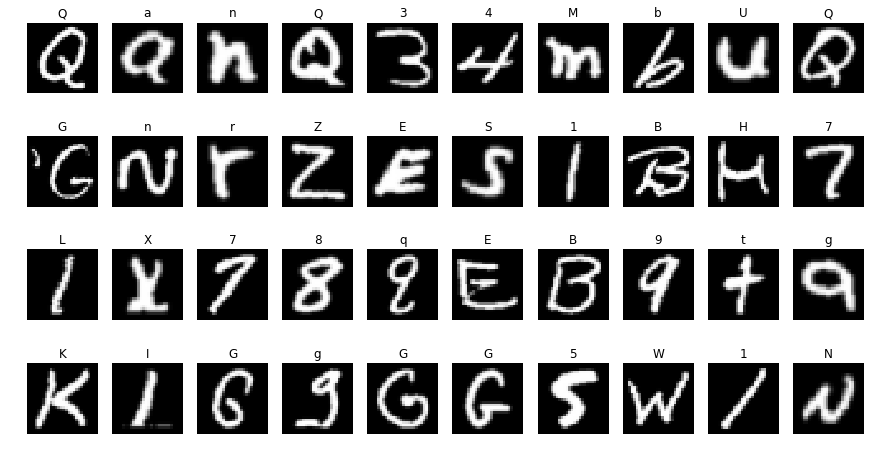

In [10]:
# Plot sample images
plot_grid(get_index())

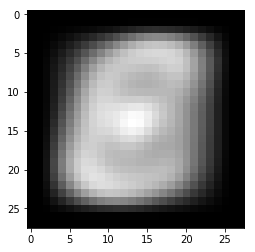

In [11]:
# Plot ROI of input data set
tmp1 = np.array(np.mean(train_x, axis=0))
plt.imshow(tmp1, cmap=plt.get_cmap('gray'))

In [12]:
# Confirm number of classes
num_classes = len(class_map)
assert (num_classes == train_y.nunique())
num_classes

47

In [13]:
# One hot encoding
num_classes = len(class_map)
train_y = np_utils.to_categorical(train_y, num_classes)
test_y  = np_utils.to_categorical(test_y,  num_classes)
print (f'train_y: {train_y.shape}\n test_y: {test_y.shape}')

train_y: (112799, 47)
 test_y: (18799, 47)


In [14]:
# Reshape image for CNN
train_x = train_x.reshape(-1, HEIGHT, WIDTH, 1)
test_x  = test_x.reshape (-1, HEIGHT, WIDTH, 1)
print (f'train_x: {train_x.shape}\n test_x: {test_x.shape}')

train_x: (112799, 28, 28, 1)
 test_x: (18799, 28, 28, 1)


In [15]:
# Build the model
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(5,5), padding = 'same', activation='relu',\
                 input_shape=(HEIGHT, WIDTH,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3) , padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)      

In [16]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# Generate the model
history = model.fit(train_x, train_y, epochs=10, batch_size=512, verbose=1, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 101519 samples, validate on 11280 samples
Epoch 1/10
101519/101519 [==============================] - 295s 3ms/step - loss: 1.5515 - acc: 0.5602 - val_loss: 0.5564 - val_acc: 0.8168
Epoch 2/10
101519/101519 [==============================] - 291s 3ms/step - loss: 0.7412 - acc: 0.7646 - val_loss: 0.4529 - val_acc: 0.8439
Epoch 3/10
101519/101519 [==============================] - 293s 3ms/step - loss: 0.6069 - acc: 0.8033 - val_loss: 0.4059 - val_acc: 0.8570
Epoch 4/10
101519/101519 [==============================] - 293s 3ms/step - loss: 0.5459 - acc: 0.8200 - val_loss: 0.3823 - val_acc: 0.8645
Epoch 5/10
101519/101519 [==============================] - 293s 3ms/step - loss: 0.5025 - acc: 0.8317 - val_loss: 0.3683 - val_acc: 0.8629
Epoch 6/10
101519/101519 [==============================] - 295s 3ms/step - loss: 0.4714 - acc: 0.8416 - val_loss: 0.3583 - val_acc: 0.8675
Epoch 7/10
101519/101519 [==============================] - 2

In [18]:
# Save accuracy, loss data in data frame
hdf = pd.DataFrame(history.history)
hdf

,val_loss,val_acc,loss,acc
0,0.556444,0.816844,1.551450,0.560161
1,0.452905,0.843883,0.741174,0.764556
2,0.405882,0.857004,0.606898,0.803308
3,0.382344,0.864450,0.545877,0.819955
4,0.368311,0.862943,0.502502,0.831697
5,0.358343,0.867465,0.471394,0.841636
6,0.349220,0.873316,0.445639,0.847831
7,0.354153,0.870301,0.430361,0.851722
8,0.340421,0.874113,0.411845,0.856303
9,0.337546,0.876241,0.395675,0.862834


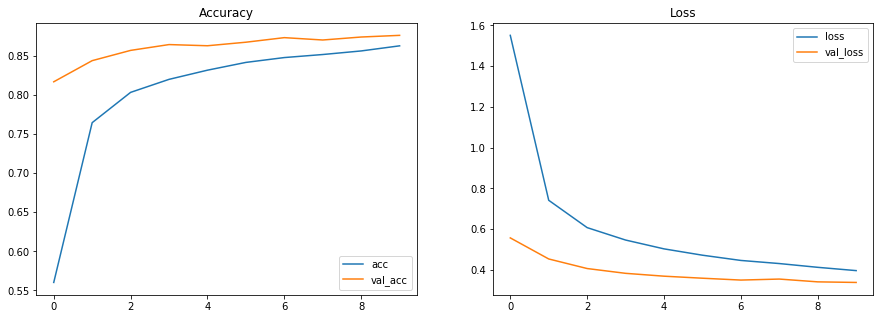

In [24]:
# Plot statistics from training
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(list(hdf.index), hdf['acc'], label='acc')
plt.plot(list(hdf.index), hdf['val_acc'], label='val_acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(list(hdf.index), hdf['loss'], label='loss')
plt.plot(list(hdf.index), hdf['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

In [22]:
# Save the traing statistics
hdf.to_csv('./emnist_cnn_history.csv')

In [19]:
# Evaluate model results on the test data
model.evaluate(test_x, test_y, batch_size=512, verbose=1)

18799/18799 [==============================] - 21s 1ms/step


[0.34724802725542997, 0.881004308711291]

In [20]:
# Save the model to file for use in application
model.save('./cnn_model.hd5')

In [21]:
# Load the saved model and confirm original results
ldmodel = load_model('./cnn_model.hd5')

ldmodel.evaluate(test_x, test_y, batch_size=512, verbose=1)

18799/18799 [==============================] - 21s 1ms/step


[0.34724802725542997, 0.881004308711291]

In [25]:
# Evaluate the model misses
# Get model outputs by category
pred_y = ldmodel.predict_classes(test_x)

In [26]:
# Get indicies for missed categories
real_y = (np.argmax(test_y, axis=1))
missed = pred_y != real_y
miss_y = pred_y[missed]
real_y = real_y[missed]

In [27]:
# Convert missed indicies to missed categories
real = [class_map[i] for i in real_y]
miss = [class_map[i] for i in miss_y]
df = pd.DataFrame([[real[i],miss[i]] for i in range(len(real))], columns=['real', 'miss'])

In [28]:
# Show ordered list of missed categories
df.groupby('real', sort=False).count().sort_values('miss',ascending=False)

,miss
real,
L,213
F,182
q,177
g,158
1,132
O,131
I,118
f,109
0,108
